In [1]:
import json

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pan20 import fake, util
from pan20.util import lexicons, text

In [2]:
df = fake.load()
df['toks'] = df.tweet.apply(text.tokenize)

In [10]:
with open('data/fake/mylex.json') as f:
    lex = json.loads(f.read())['words']

def anger_score(toks):
    n = len(toks)
    c = sum(1 for t in toks if t in lex)
    return c / n

df['anger'] = df.toks.apply(anger_score)

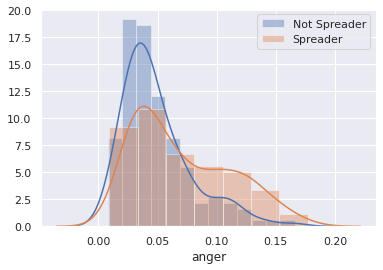

In [11]:
dfg = df.groupby(['author', 'label']).mean().reset_index()
_ = sns.distplot(dfg[dfg.label == False].anger, label='Not Spreader')
_ = sns.distplot(dfg[dfg.label == True].anger, label='Spreader')
plt.legend()
plt.show()